# Heterogeneity in Dahu

In [1]:
import io
import zipfile
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(archive.read(csv_name)), names=columns)
    df.columns = df.columns.str.strip()
    return df

directory = 'heterogeneity_exp/'

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import os
import yaml

def read_file(archive_name, csv_name, columns=None):
    df = read_csv(archive_name, csv_name, columns)
    info = yaml.load(zipfile.ZipFile(archive_name).read('info.yaml'))
    nodes = [key for key in info if key.endswith('grid5000.fr')]
    assert len(nodes) == 1
    node = nodes[0]
    node = node[:node.index('.')]
    node = int(node[node.index('-')+1:])
    df['node'] = node
    df['index'] = range(len(df))
    return df

def read_dir(directory, csv_name, columns=None):
    dataframes = []
    for file in os.listdir(directory):
        dataframes.append(read_file(os.path.join(directory, file), csv_name, columns))
    return pandas.concat(dataframes)

columns = ['function', 'size', 'timestamp', 'time']

df_multicore = read_dir(directory, 'result_multicore.csv', columns)
df_monocore = read_dir(directory, 'result_monocore.csv', columns)
df_monocore_contention = read_dir(directory, 'result_monocore_contention.csv', columns)

df_multicore.head()

,function,size,timestamp,time,node,index
0,dtrsm,2798,0.000001,0.075513,2,0
1,dtrsm,2798,0.075540,0.046288,2,1
2,dtrsm,2798,0.121835,0.034649,2,2
3,dgemm,2798,0.156491,0.059439,2,3
4,dgemm,2798,0.215935,0.059207,2,4


In [3]:
import statsmodels.formula.api as sm

for df in [df_multicore, df_monocore, df_monocore_contention]:
    df['size_cube'] = df['size'].astype(float) ** 3
    df['intercept'] = -1
    df['coefficient'] = -1
    for node in df.node.unique():
        for func in df.function.unique():
            reg = sm.ols(data=df[(df.node == node) & (df.function == func)], formula='time ~ size_cube').fit()
            df.loc[(df.node == node) & (df.function == func), 'intercept'] = reg.params.Intercept
            df.loc[(df.node == node) & (df.function == func), 'coefficient'] = reg.params.size_cube

In [4]:
def plot_basic(df, x, y, color):
    return ggplot(df[(df.node <= 8)], aes(x=x, y=y, color=color)) + geom_point() + facet_wrap(['function', 'node'], nrow=2) + theme_bw()

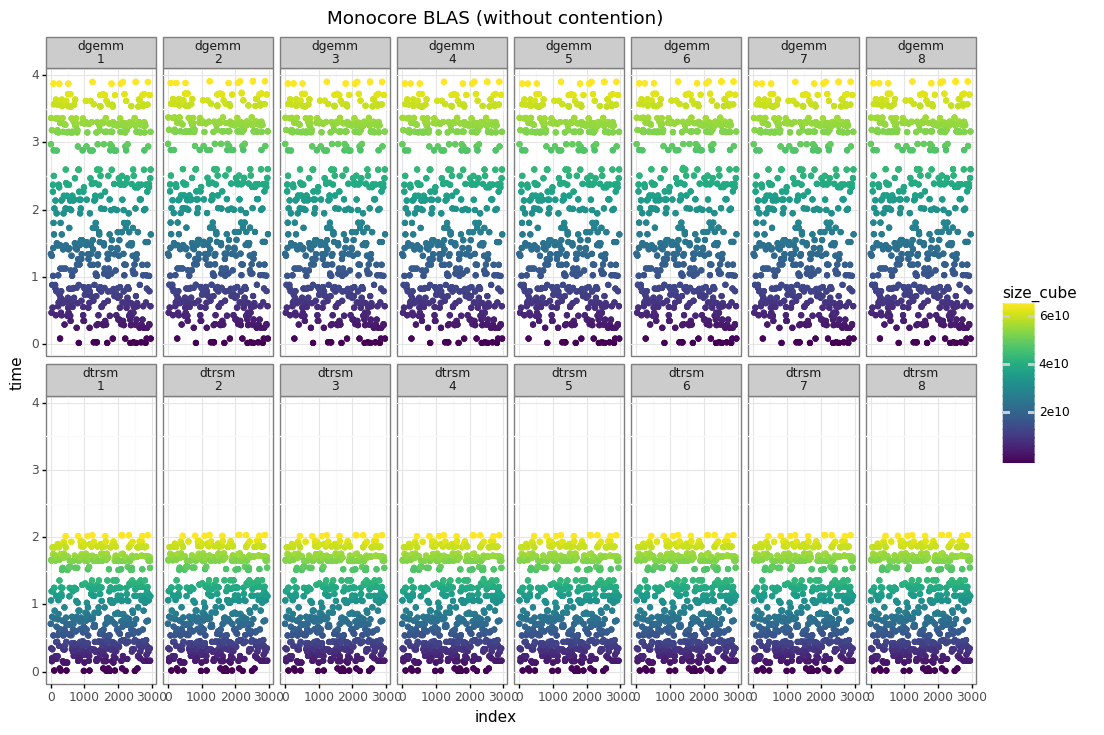

<ggplot: (-9223363255905056915)>

In [5]:
plot_basic(df_monocore, x='index', y='time', color='size_cube') + ggtitle('Monocore BLAS (without contention)')

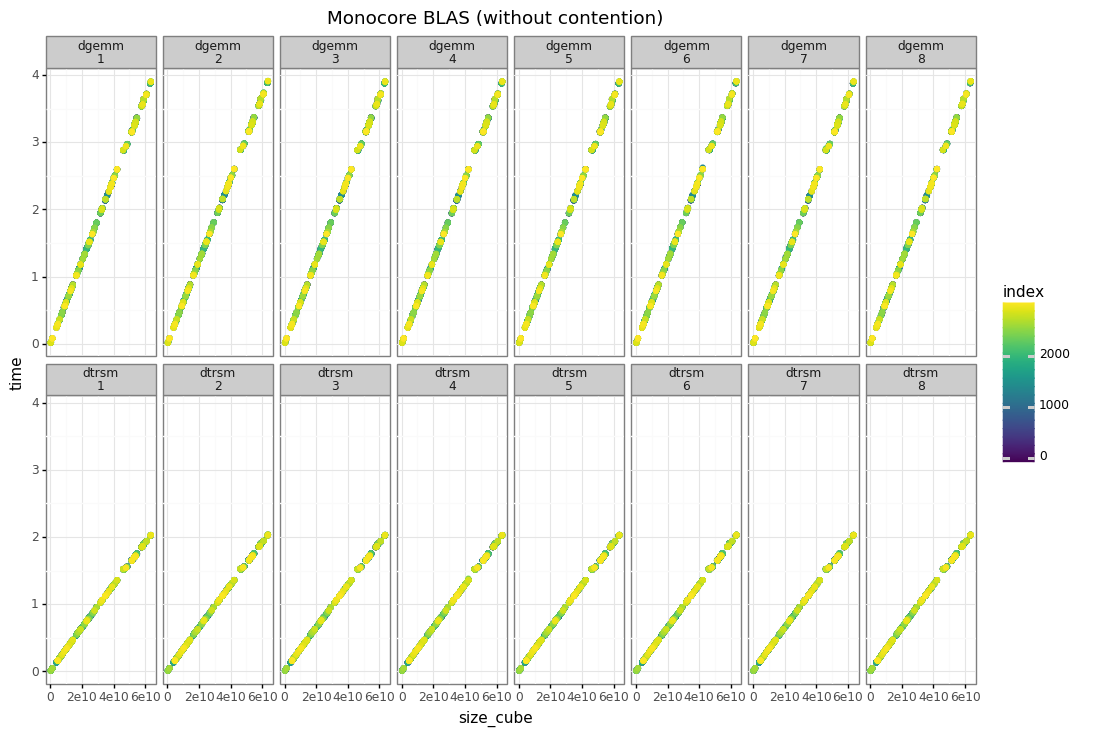

<ggplot: (8780949568460)>

In [6]:
plot_basic(df_monocore, x='size_cube', y='time', color='index') + ggtitle('Monocore BLAS (without contention)')

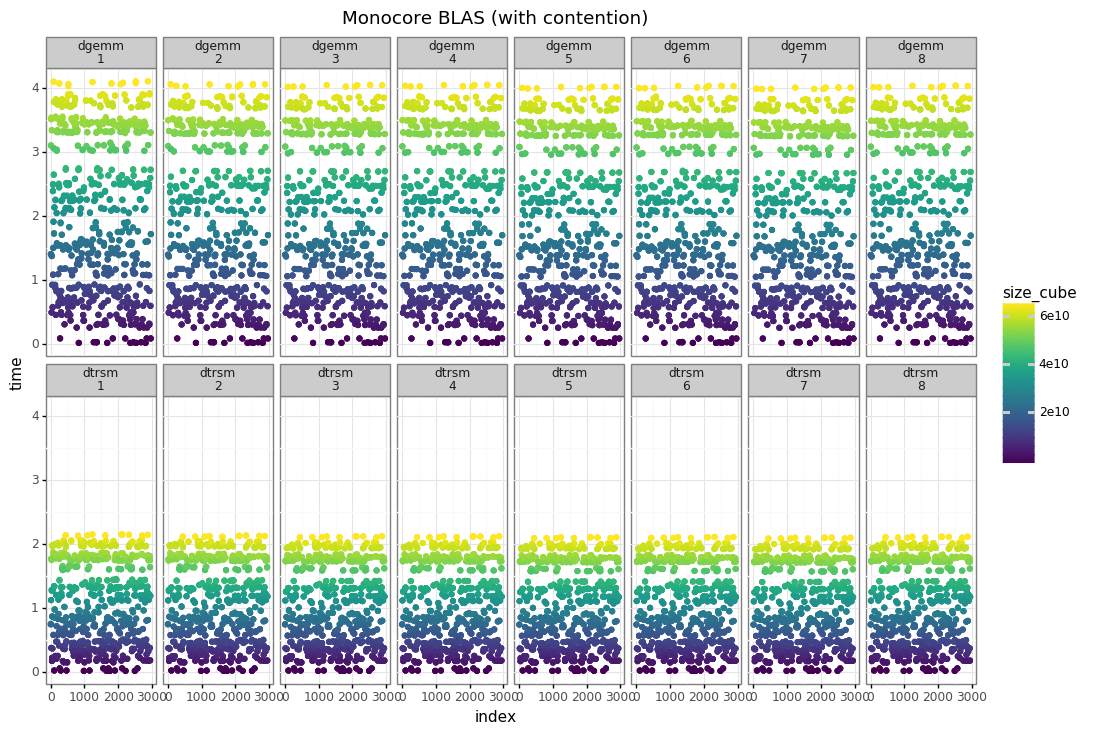

<ggplot: (8780945135480)>

In [7]:
plot_basic(df_monocore_contention, x='index', y='time', color='size_cube') + ggtitle('Monocore BLAS (with contention)')

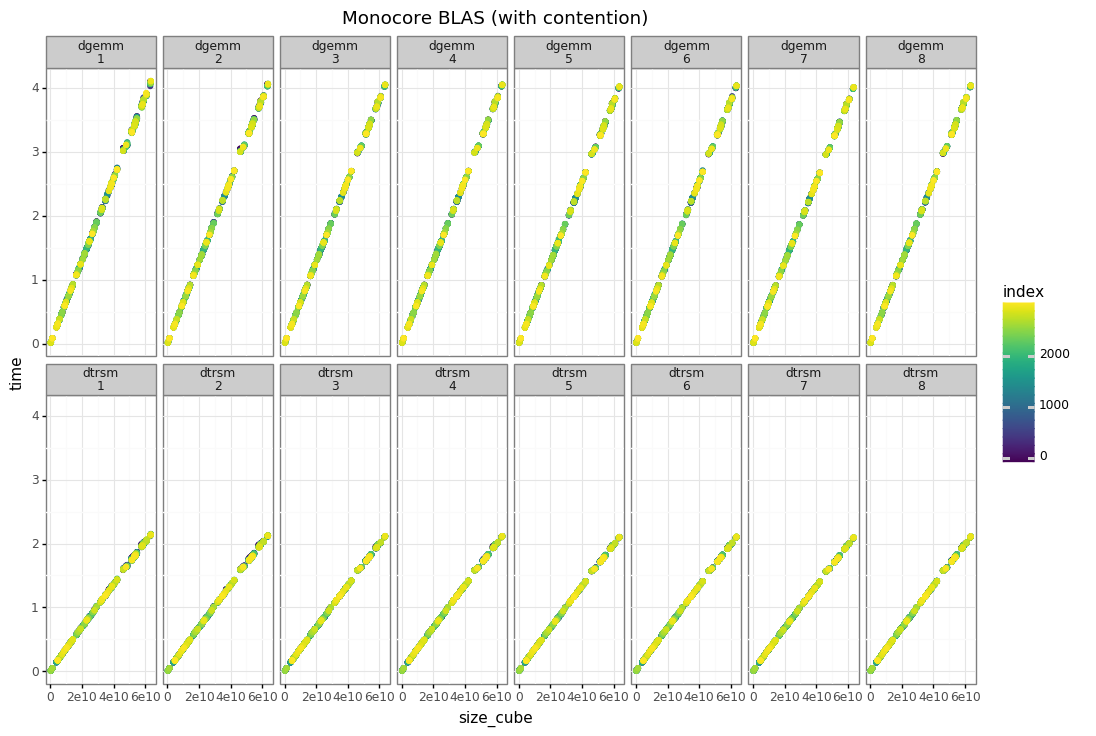

<ggplot: (-9223363255905126705)>

In [8]:
plot_basic(df_monocore_contention, x='size_cube', y='time', color='index') + ggtitle('Monocore BLAS (with contention)')

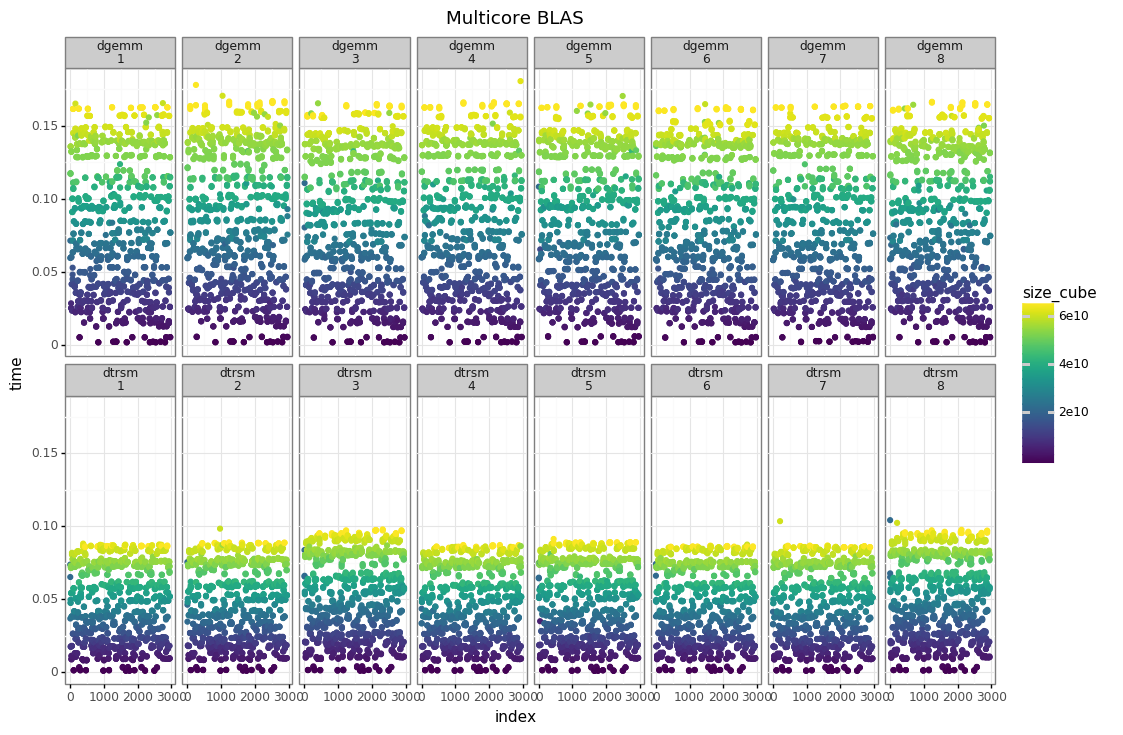

<ggplot: (-9223363255909972045)>

In [9]:
plot_basic(df_multicore, x='index', y='time', color='size_cube') + ggtitle('Multicore BLAS')

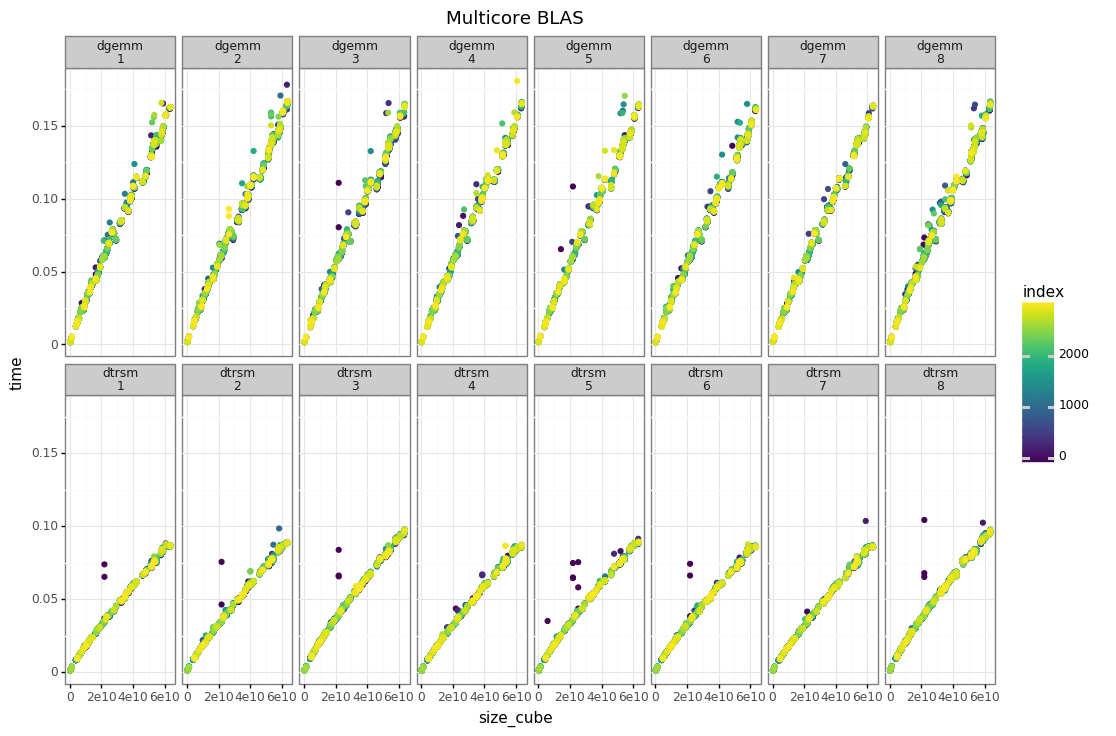

<ggplot: (-9223363255909196940)>

In [10]:
plot_basic(df_multicore, x='size_cube', y='time', color='index') + ggtitle('Multicore BLAS')

## Graphical representation of the coefficients

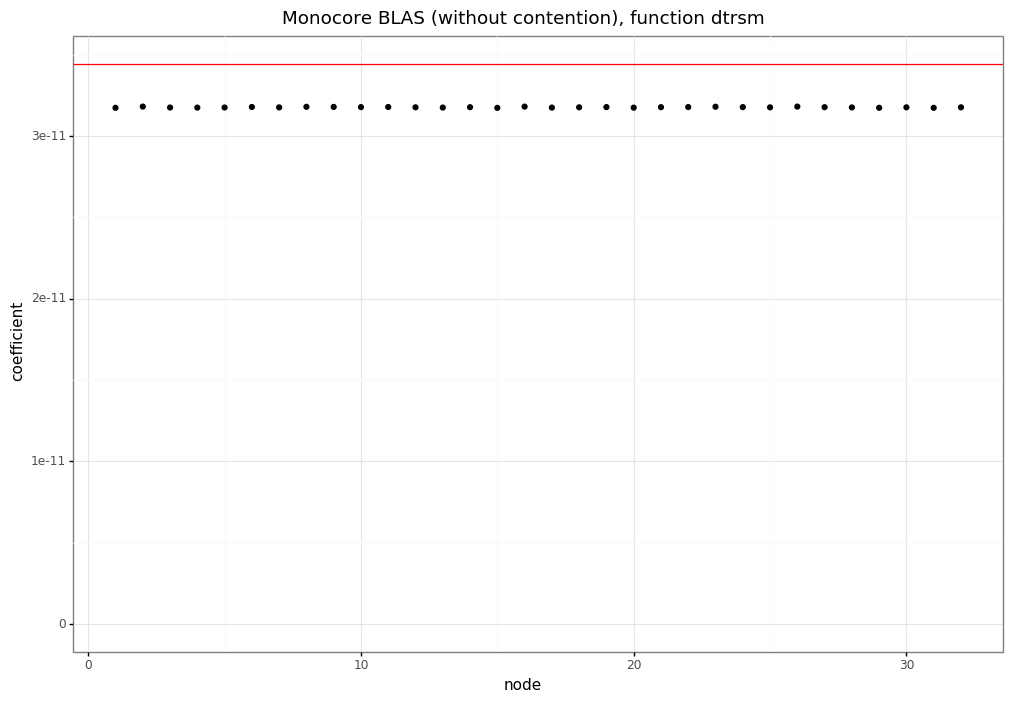

<ggplot: (-9223363255909948598)>


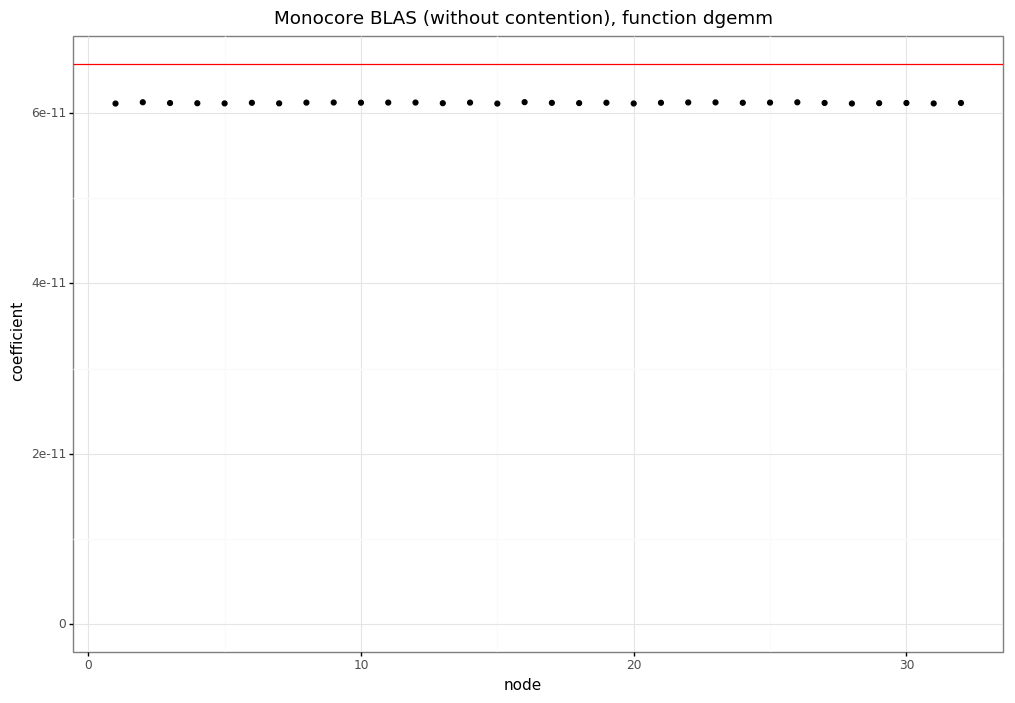

<ggplot: (-9223363255905754936)>


In [11]:
coefficients = {
    'dgemm': 6.576115e-11,
    'dtrsm': 3.441913e-11,
}

def plot(df, title, lines=None):
    for func in df.function.unique():
        tmp = df[df.function == func].groupby('node').mean().reset_index()
        plot = ggplot(tmp, aes(x='node', y='coefficient')) + theme_bw()
        plot = plot + geom_point() + expand_limits(y=0) + ggtitle(func) + ggtitle(title + ', function %s' % func)
        if lines:
            plot += geom_hline(yintercept=coefficients[func], color='red')
        print(plot)

plot(df_monocore,  'Monocore BLAS (without contention)', coefficients)

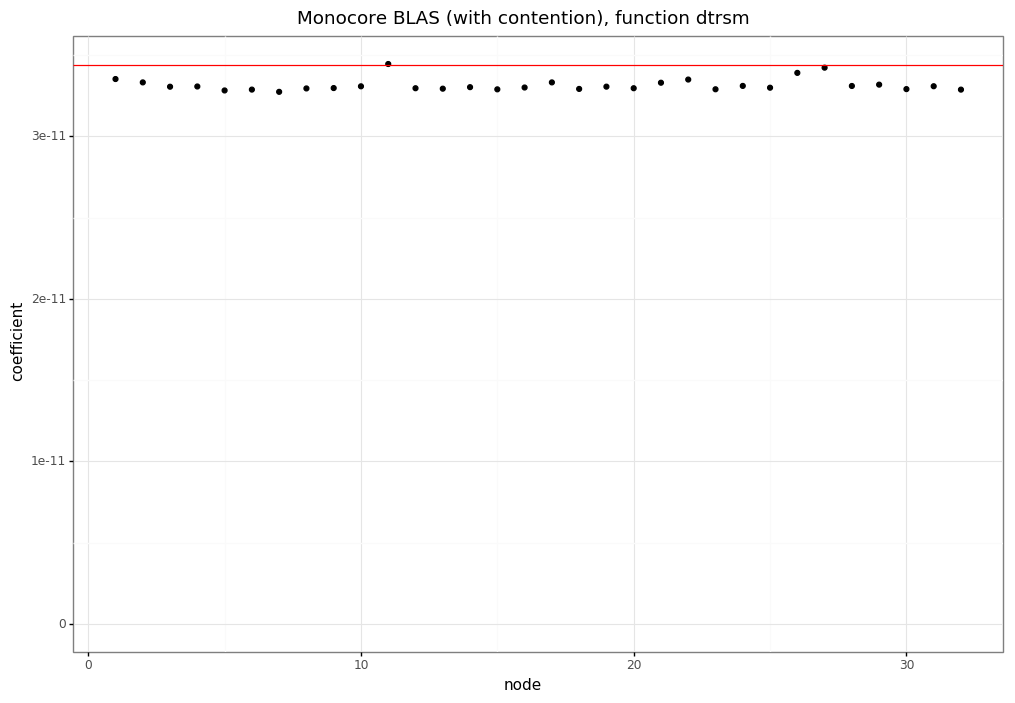

<ggplot: (8780945676492)>


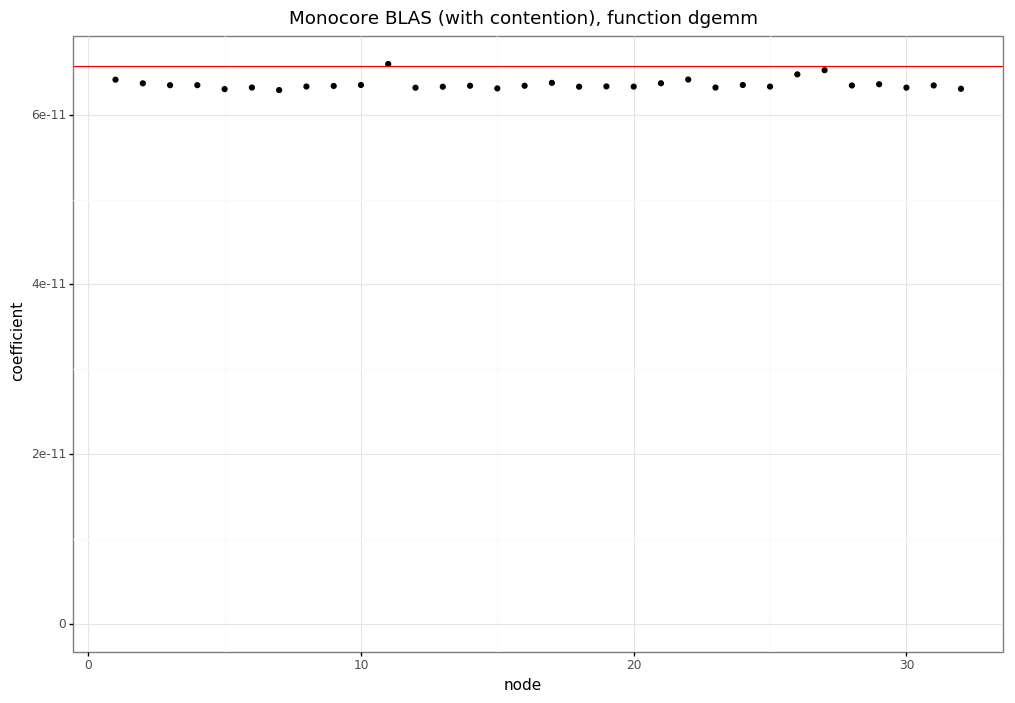

<ggplot: (8780949031912)>


In [12]:
plot(df_monocore_contention,  'Monocore BLAS (with contention)', coefficients)

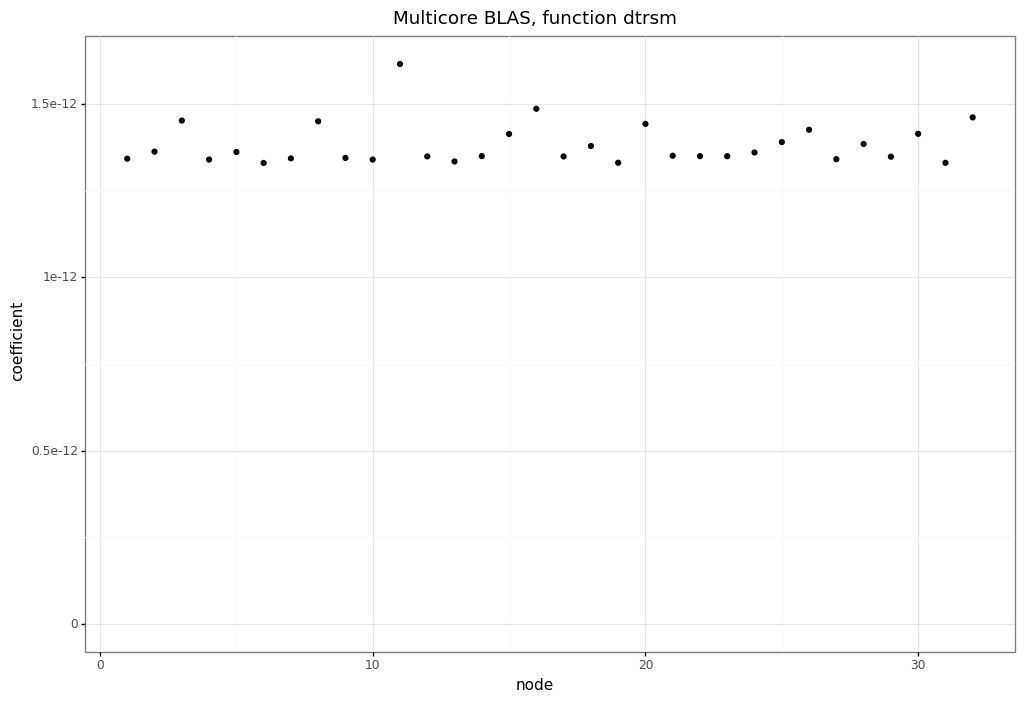

<ggplot: (8780949034374)>


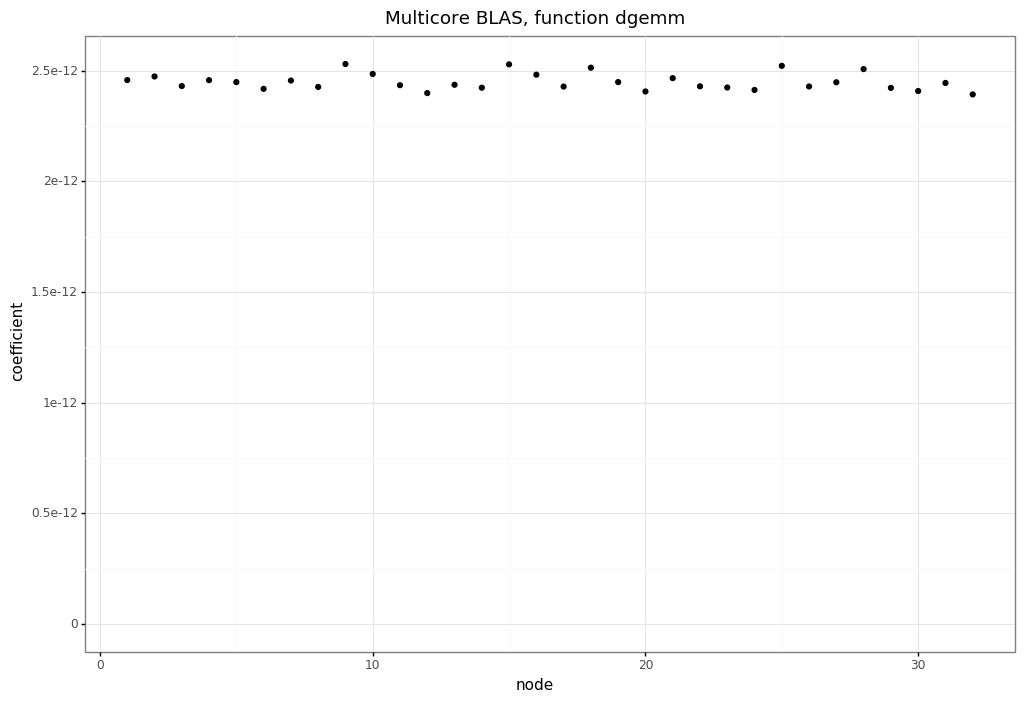

<ggplot: (-9223363255909095957)>


In [13]:
plot(df_multicore,  'Multicore BLAS')

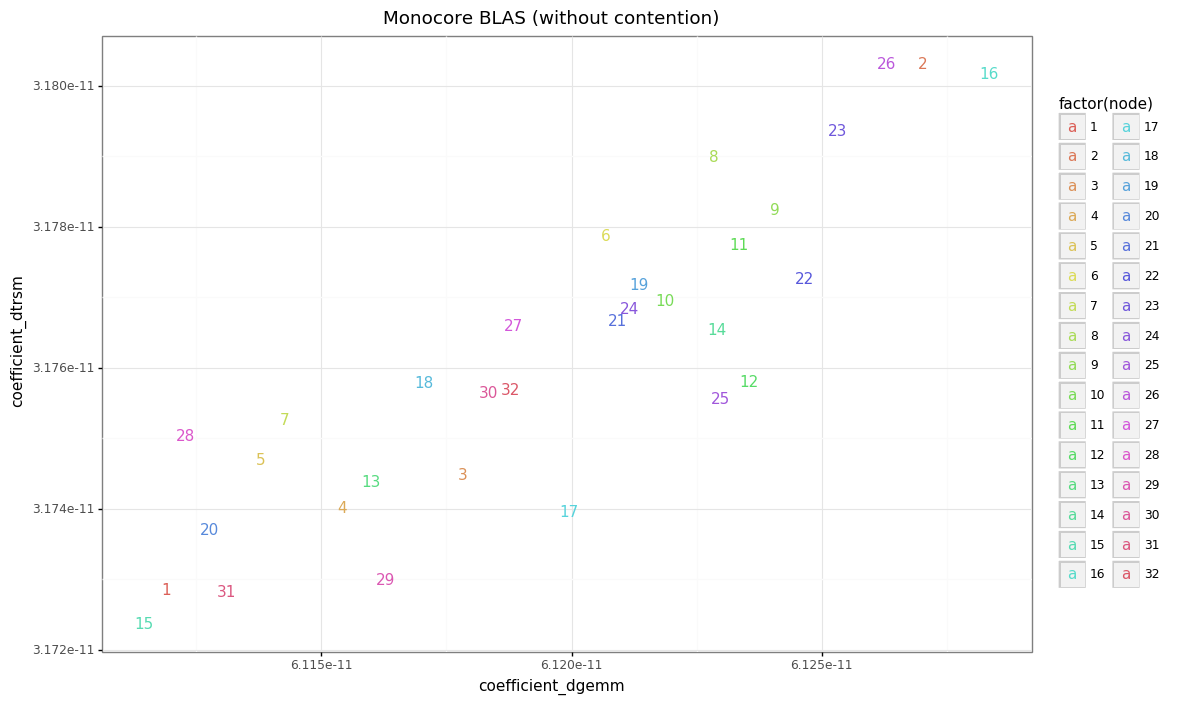

<ggplot: (-9223363255905087607)>

In [14]:
def plot_dgemm_vs_dtrsm(df):
    tmp_dgemm = df[df.function == 'dgemm'].groupby('node').mean().reset_index()
    tmp_dtrsm = df[df.function == 'dtrsm'].groupby('node').mean().reset_index()
    df = tmp_dgemm.set_index('node').join(tmp_dtrsm.set_index('node'), rsuffix='_dtrsm').reset_index()
    plot = ggplot(df, aes(x='coefficient', y='coefficient_dtrsm', color='factor(node)')) + theme_bw() + xlab('coefficient_dgemm')
    plot += geom_text(aes(label='node'))
    return plot

plot_dgemm_vs_dtrsm(df_monocore) + ggtitle('Monocore BLAS (without contention)')

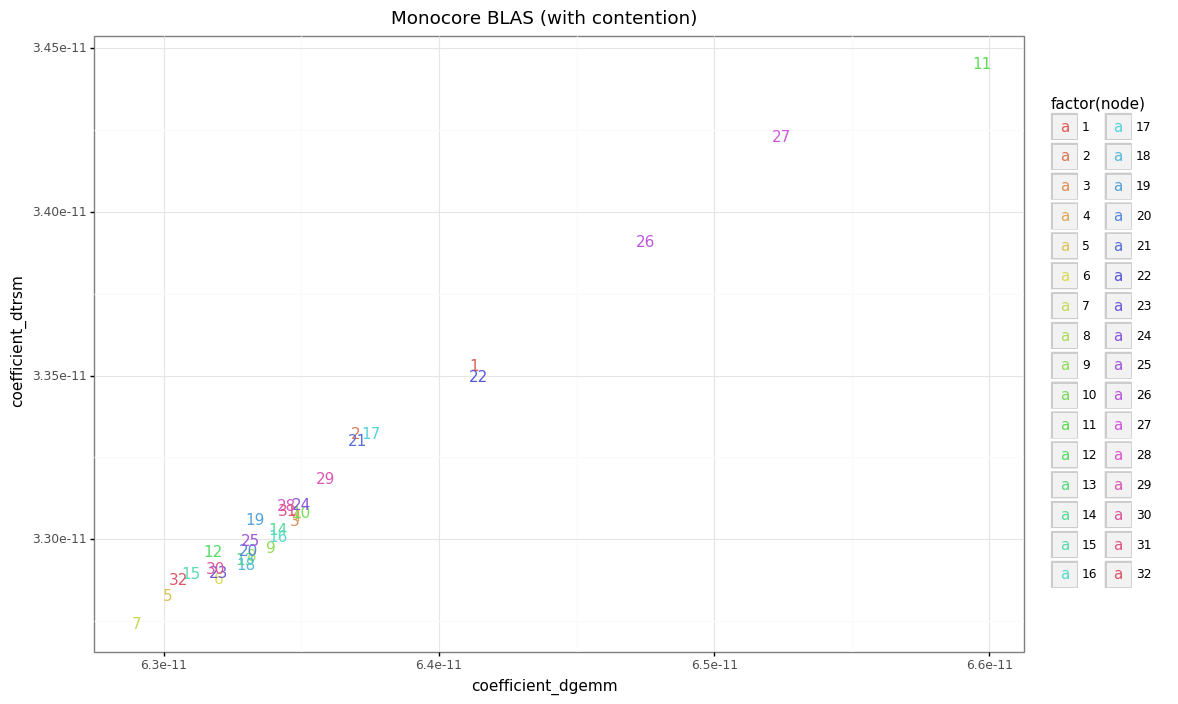

<ggplot: (8780949788564)>

In [15]:
plot_dgemm_vs_dtrsm(df_monocore_contention) + ggtitle('Monocore BLAS (with contention)')

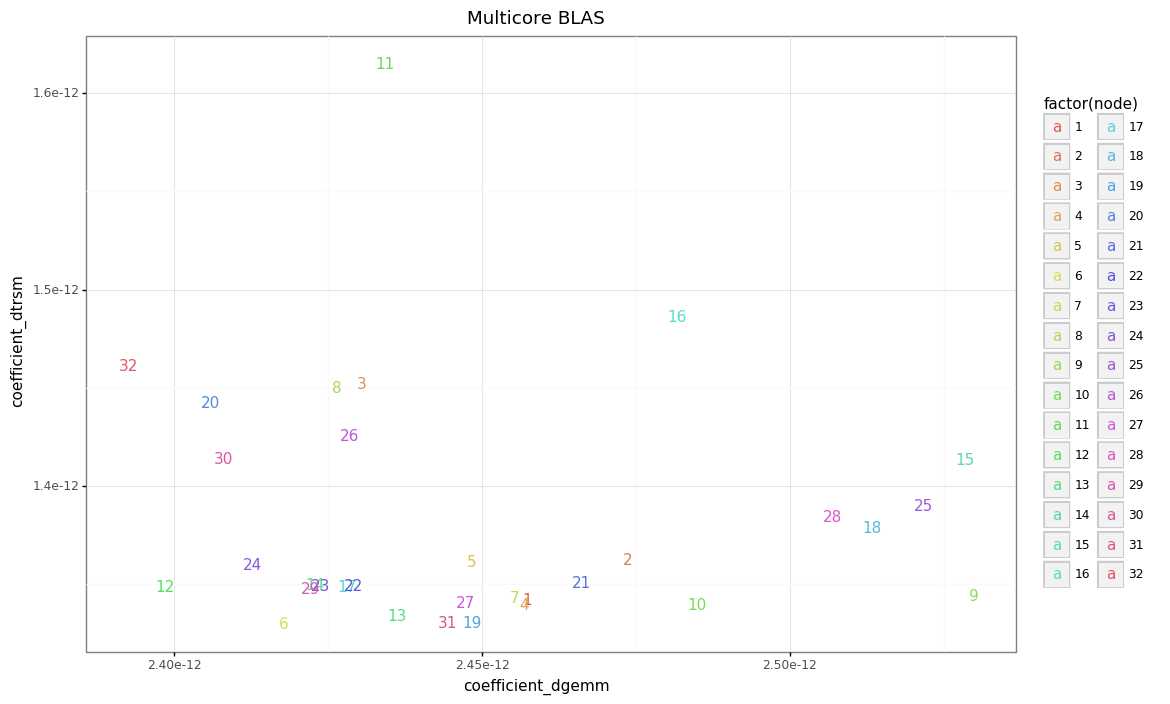

<ggplot: (-9223363255909859573)>

In [16]:
plot_dgemm_vs_dtrsm(df_multicore) + ggtitle('Multicore BLAS')

## BLAS coefficients vs HPL performance

In [17]:
df_hpl = read_dir('../hpl/heterogeneity_exp/', 'results.csv')
df_hpl.head()

,bcast,block_size,depth,gflops,index,matrix_size,mem_align,node,pfact,proc_p,proc_q,process_per_node,residual,rfact,swap,thread_per_process,time
0,2,128,1,793.8,0,65536,8,1,1,4,8,32,0.001254,2,0,1,236.40
1,2,128,1,796.5,1,65536,8,1,1,4,8,32,0.001254,2,0,1,235.60
2,2,128,1,798.4,2,65536,8,1,1,4,8,32,0.001254,2,0,1,235.05
3,2,128,1,805.7,3,65536,8,1,1,4,8,32,0.001254,2,0,1,232.91
4,2,128,1,810.0,4,65536,8,1,1,4,8,32,0.001254,2,0,1,231.67


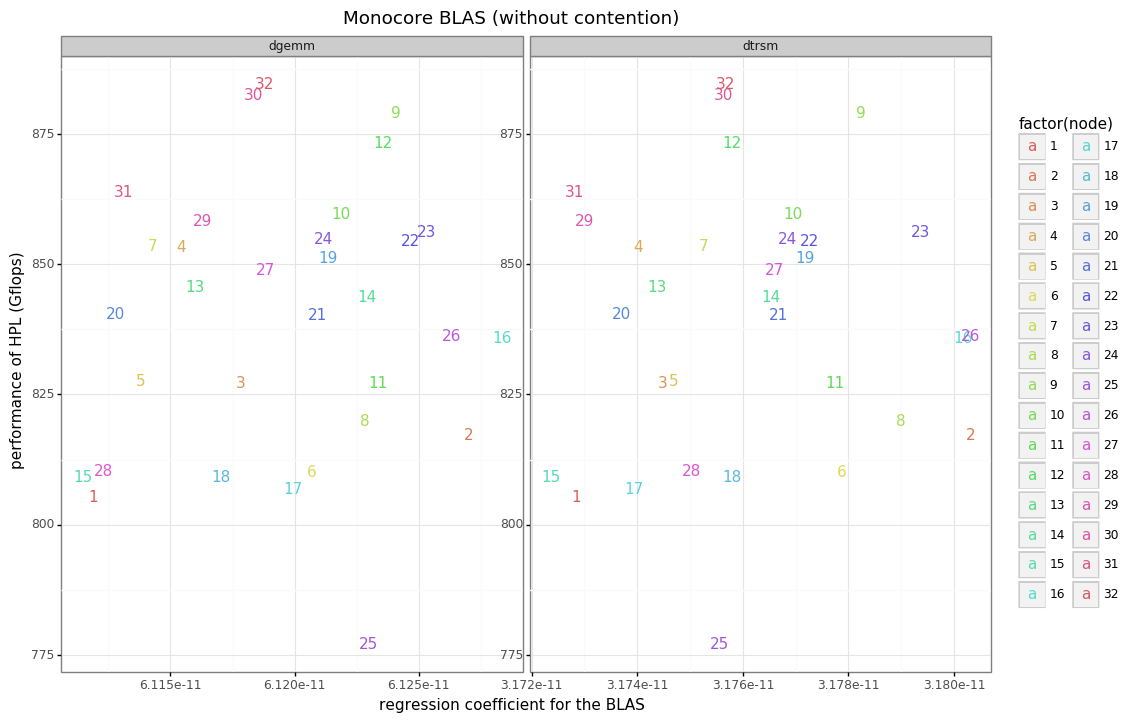

<ggplot: (-9223363255905740891)>

In [18]:
def plot_blas_vs_hpl(df_blas, df_hpl, function='dgemm'):
    tmp_blas = df_blas.groupby(['node', 'function']).mean().reset_index()
    tmp_hpl = df_hpl.groupby('node').mean().reset_index()
    df = tmp_blas.set_index('node').join(tmp_hpl.set_index('node'), rsuffix='_hpl').reset_index()
    plot = ggplot(df, aes(x='coefficient', y='gflops', color='factor(node)')) + theme_bw() + facet_wrap('function', scales='free')
    plot = plot + geom_text(aes(label='node')) + xlab('regression coefficient for the BLAS') + ylab('performance of HPL (Gflops)')
    return plot

plot_blas_vs_hpl(df_monocore, df_hpl) + ggtitle('Monocore BLAS (without contention)')

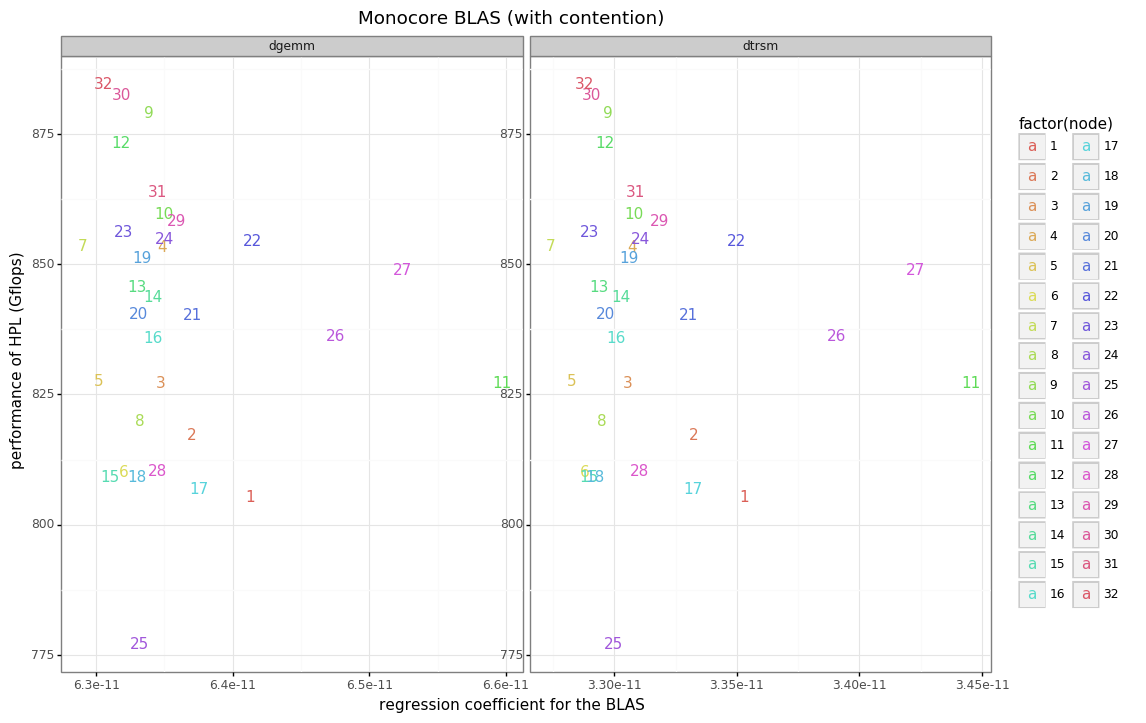

<ggplot: (-9223363255909997873)>

In [19]:
plot_blas_vs_hpl(df_monocore_contention, df_hpl) + ggtitle('Monocore BLAS (with contention)')

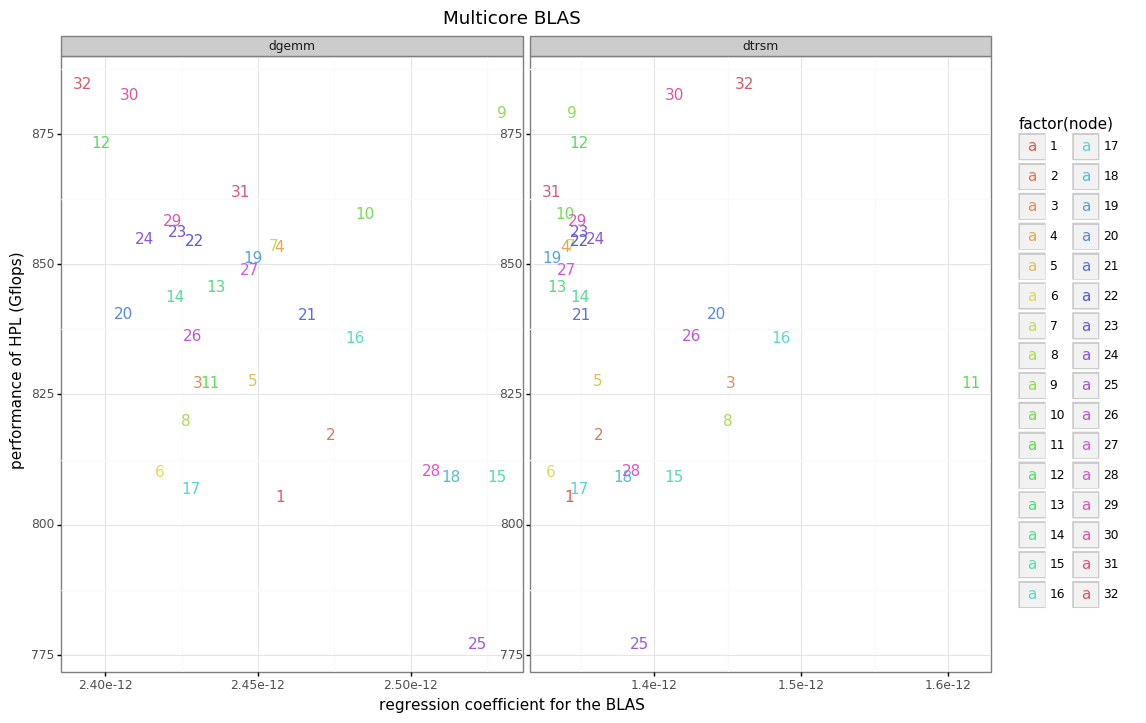

<ggplot: (8780945394696)>

In [20]:
plot_blas_vs_hpl(df_multicore, df_hpl) + ggtitle('Multicore BLAS')